In [105]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [106]:
import scipy.io

In [107]:
OUT_DIR='/raid0/homes/aghayoor/Desktop/phantom'

In [108]:
t1=sitk.Image(128,128,sitk.sitkUInt8)
t2=sitk.Image(128,128,sitk.sitkUInt8)

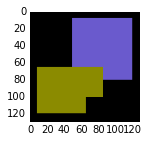

In [109]:
# create modality 1
#
t1_arr=sitk.GetArrayFromImage(t1)
t1_arr[8:65,49:119]=50 # tissue A or c
t1_arr[65:80,85:119]=50 # tissue A or C
t1_arr[65:119,8:85]=250 # tissue B
t1_arr[100:127,65:127]=0
#
t1=sitk.GetImageFromArray(t1_arr)
myshow(sitk.LabelToRGB(t1))

In [110]:
sitk.WriteImage(t1,os.path.join(OUT_DIR,'t1.nii.gz'))
scipy.io.savemat(os.path.join(OUT_DIR,'t1.mat'), mdict={'t1': t1_arr})

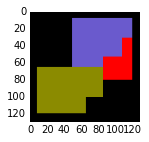

In [111]:
# create modality 2
#
t2_arr=sitk.GetArrayFromImage(t2)
t2_arr[8:65,49:119]=200 # tissue A
t2_arr[65:119,8:85]=100 # tissue B
t2_arr[100:127,65:127]=0
t2_arr[31:80,85:119]=150 # tissue C
t2_arr[31:53,85:107]=200 # tissue A
#
t2=sitk.GetImageFromArray(t2_arr)
myshow(sitk.LabelToRGB(t2))

In [112]:
sitk.WriteImage(t2,os.path.join(OUT_DIR,'t2.nii.gz'))
scipy.io.savemat(os.path.join(OUT_DIR,'t2.mat'), mdict={'t2': t2_arr})

(12, 12)
(10.0, 10.0)


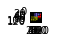

In [113]:
t2_lr = sitk.Shrink(t2,[10,10])
myshow(sitk.LabelToRGB(t2_lr))

print(t2_lr.GetSize())
print(t2_lr.GetSpacing())

In [114]:
sitk.WriteImage(t2_lr,os.path.join(OUT_DIR,'t2_lr.nii.gz'))

t2_lr_arr=sitk.GetArrayFromImage(t2_lr)
scipy.io.savemat(os.path.join(OUT_DIR,'t2_lr.mat'), mdict={'t2_lr': t2_lr_arr})

In [115]:
# compute pure plugs mask
#
#
#

In [116]:
#t2_lr=t2

In [117]:
purePlugsMask = sitk.Image(t2_lr.GetSize(),sitk.sitkUInt8)
purePlugsMask.CopyInformation(t2_lr)
#print(purePlugsMask)

In [118]:
def isPurePlug(idx, t2_lr, t1):
    # high spacing (low resolution)
    hspc=np.array(t2_lr.GetSpacing())
    # low spacing (high resolution)
    lspc=np.array(t1.GetSpacing())

    factor=hspc/lspc
    stepSize=1/factor

    hResSize = t1.GetSize()
    
    # continues index
    cidx=np.array([float(i) for i in idx])
    #print('----------------------------')
    #print("index: {0}".format(cidx)) # <-----
    p = t2_lr.TransformContinuousIndexToPhysicalPoint(cidx)
    #print(p)
    #
    isInside = True
    t1_sampleValues=[]
    for iss in np.arange(cidx[0]-1.0/2+stepSize[0]/2,cidx[0]+1.0/2,stepSize[0]):
        for jss in np.arange(cidx[1]-1.0/2+stepSize[1]/2,cidx[1]+1.0/2,stepSize[1]):
            cssidx=[iss, jss]
            #
            #print("continus subsample: {0}".format(cssidx)) # <-----
            #
            p = t2_lr.TransformContinuousIndexToPhysicalPoint(cssidx)
            #
            #print("point: {0}".format(p)) # <-----
            #
            newidx = t1.TransformPhysicalPointToIndex(p)
            #
            #print("newidx: {0}".format(newidx)) # <-----
            #
            if any( newidx[i] < 0 or newidx[i] >= hResSize[i] for i in range(len(newidx))):
                isInside = False
                #
                #print("is not inside") # <-----
                #
                break
            else:
                t1_value = t1[newidx]
                t1_sampleValues.append(t1_value)
        else:
            continue
        break

    ispure = False
    if isInside:
        #
        #print("sample values: ") # <-----
        #print(t1_sampleValues) # <-----
        #
        t1_arr = np.array(t1_sampleValues)
        # First check to see wether the variance is zero
        # In this case, surely we have a pure plug
        var_t1 = np.var(t1_arr)
        #
        #print("var: {0}".format(var_t1)) # <-----
        #
        if var_t1 == 0: # it means that the std in at least one image is zero 
            ispure = True
        else:
            ispure = False
    #
    #print("Is pure: {0}".format(ispure)) # <-----
    #
    return ispure

In [119]:
t2_lr_size = t2_lr.GetSize()

for i in range(0,t2_lr_size[0]):
  for j in range(0,t2_lr_size[1]):
      idx=[i,j]
      if( isPurePlug(idx,t2_lr,t1) ):
        purePlugsMask[idx] = 1
      else:
        purePlugsMask[idx] = 0

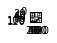

In [120]:
myshow(purePlugsMask)
sitk.WriteImage(purePlugsMask,os.path.join(OUT_DIR,'pureplugs_mask.nii.gz'))